In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('data/employees_cleaned_data.csv', index_col=0)

In [3]:
df.columns

Index(['floor', 'space-type - Selected Choice', 'space-type - Others - Text',
       'emotion', 'comfort'],
      dtype='object')

In [4]:
df.describe()

,floor,space-type - Selected Choice,space-type - Others - Text,emotion,comfort
count,69,68,1,62,61
unique,4,3,1,62,60
top,5th Floor,Shared room,Flexroom,"Good, there could be more plants",Very comfortable
freq,30,62,1,1,2


In [5]:
df = df.rename(columns={"space-type - Selected Choice": "space-type",
                        "space-type - Others - Text": "space-type-others"})

In [6]:
df = df.replace("Ground floor", "3rd Floor")

In [7]:
df['space-type'].value_counts()

Shared room     62
Private room     5
Others           1
Name: space-type, dtype: int64

# Responses Across the Building 904

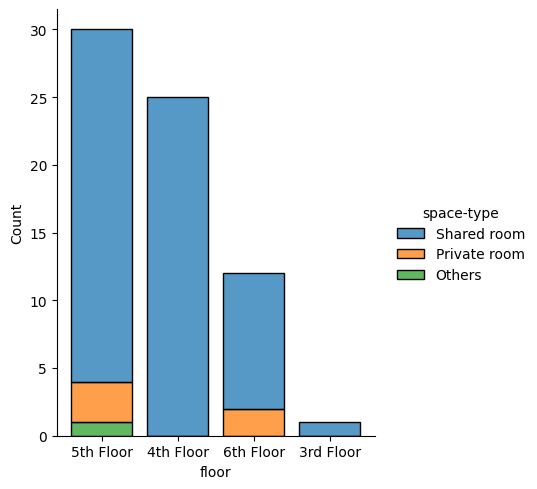

In [8]:
# fig, ax = plt.subplots()
sns.displot(df, x="floor",
            hue="space-type",
            multiple="stack",
            height=5,
            aspect=0.8,
            shrink=.8)
# fig.set_size_inches(8, 5)
plt.savefig('plots/employees-floors-responses.jpg', dpi=300, bbox_inches="tight")

# Emotions

In [9]:
df_emo = df.emotion.dropna()
df_emo = df_emo.apply(lambda x: x.replace('’', ''))
df_emo = df_emo.apply(lambda x: x.replace("'", ''))
df_emo = df_emo.apply(lambda x: x.replace('`', ''))

### Tokenise

In [10]:
import string

def apply_token(row):
    stop_words = set(stopwords.words("english"))
    words_in_sent = word_tokenize(row)

    filtered_list = []
    
    for word in words_in_sent:
        if word.casefold() not in stop_words:
            filtered_list.append(word)
    
    return filtered_list

In [11]:
df_emo = df_emo.apply(apply_token)

In [12]:
def cleanup(df):
    fillers = ["feel", "feels",
               "office", "bit",
               "like", "also",
               "dont", "little", "slightly"]
    
    combo_list = []
    for row in df:
        combo_list.append(row)
    
    combo_list = list(np.concatenate(combo_list).flat)
    combo_list = list(filter(lambda token: token not in string.punctuation,
                            combo_list))
    combo_list = list(filter(lambda token: len(token) > 2 ,
                            combo_list))
    combo_list = [x.lower() for x in combo_list]
    
    combo_list = [word for word in combo_list if word not in fillers]
    
    return combo_list

In [13]:
combo_emo_list = cleanup(df_emo)

In [14]:
frequency_distribution = FreqDist(combo_emo_list)
frequency_distribution.most_common(20)

[('calm', 10),
 ('happy', 9),
 ('good', 8),
 ('comfortable', 8),
 ('light', 5),
 ('open', 5),
 ('room', 5),
 ('positive', 4),
 ('cold', 4),
 ('relaxed', 4),
 ('focused', 3),
 ('space', 3),
 ('building', 3),
 ('work', 3),
 ('artificial', 3),
 ('spaces', 3),
 ('neutral', 3),
 ('stressed', 3),
 ('people', 3),
 ('enough', 3)]

In [27]:
def frequency_distribution(lst, label):
    top_n = FreqDist(lst).most_common(20)
    frequency_distribution = pd.Series(dict(top_n))

    sns.set_theme(style="ticks")
    sns.barplot(y=frequency_distribution.index,
                x=frequency_distribution.values,
                palette = 'hls',
                saturation = 8)
    plt.xlabel("Count of responses")
    plt.ylabel("Most frequently occuring responses")
    plt.gcf().set_size_inches(5,7)
    # plt.xlim(0,20)

    plt.savefig('plots/employees-' + label + '-freq-dist.jpg',
            dpi=300, bbox_inches='tight')

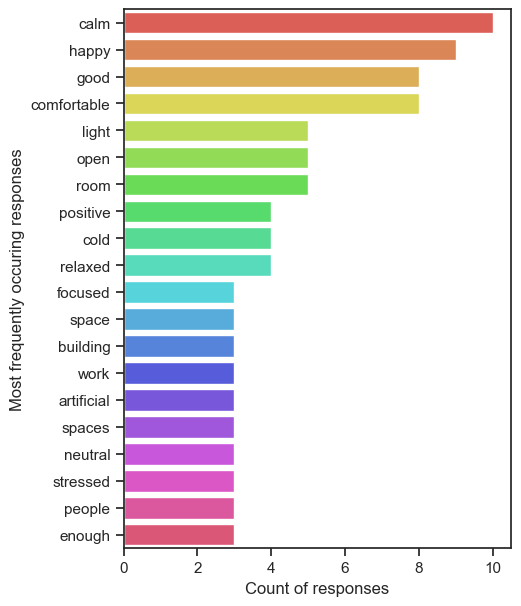

In [16]:
frequency_distribution(combo_emo_list, 'emo')

# Comfort

In [22]:
df_comfort = df.comfort.dropna()
df_comfort = df_comfort.apply(lambda x: x.replace('’', ''))

### Tokenise

In [23]:
df_comfort = df_comfort.apply(apply_token)
combo_comfort_list = cleanup(df_comfort)

In [24]:
combo_comfort_list = [word for word in combo_comfort_list if word != "'s"]

In [25]:
frequency_distribution = FreqDist(combo_comfort_list)
frequency_distribution.most_common(20)

[('comfortable', 25),
 ('temperature', 15),
 ('light', 14),
 ('good', 12),
 ('air', 10),
 ('outside', 8),
 ('quite', 8),
 ('noisy', 6),
 ('sometimes', 6),
 ('windows', 5),
 ('noise', 5),
 ('space', 5),
 ('cold', 5),
 ('fine', 4),
 ('bright', 4),
 ('much', 4),
 ('quality', 4),
 ('pretty', 3),
 ('could', 3),
 ('walls', 3)]

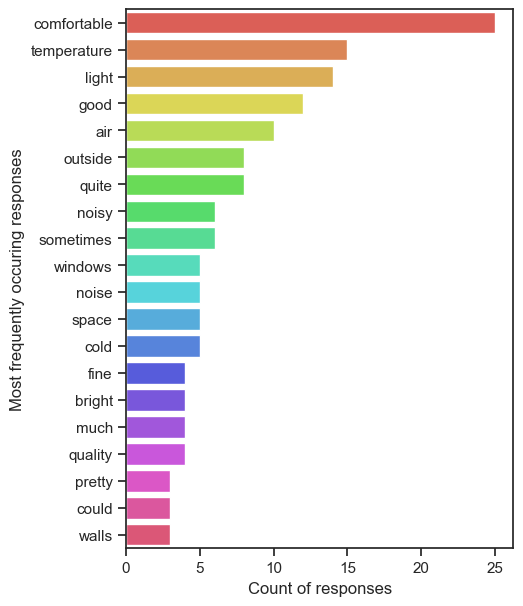

In [30]:
frequency_distribution(combo_comfort_list, 'comfort')

# Sentiment Analysis

In [28]:
def sentiment_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-polarity'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x)))
    df = pd.concat([df, df[label + '-polarity'].apply(pd.Series)], axis=1)
    df[label + '-sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

    print("Most positive emotion statement: ", df.loc[df['compound'].idxmax()].values)
    print("\n")
    print("Most negative emotion statement: ", df.loc[df['compound'].idxmin()].values)
    
    return df 

In [38]:
def plot_sentiment_analysis(df, label):
    sns.countplot(y=label+'-sentiment', 
                  data=df,
                  palette=['#b2d8d8',"#008080", '#db3d13'],
                  order=["positive", "negative", "neutral"])
    plt.ylabel("Sentiment for " + label + " Text")
    plt.xlabel("Count")
    # plt.xlim(0,45)
    plt.savefig('plots/employees-' + label + '-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')
    
    plt.clf()
    
    sns.boxplot(x='floor', y='compound', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/employees-' + label + '-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')
    
    
def plot_sentiment_analysis_spaces(df, label):
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/employees-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

Most positive emotion statement:  ['4th Floor' 'Shared room' nan
 'Great. I love my.office desk. And it is sunny'
 'Very comfortable. Perfect almost '
 {'neg': 0.0, 'neu': 0.311, 'pos': 0.689, 'compound': 0.9022}
 {'neg': 0.0, 'neu': 0.209, 'pos': 0.791, 'compound': 0.8211} 0.0 0.311
 0.689 0.9022 'positive']


Most negative emotion statement:  ['6th Floor' 'Shared room' nan
 'A little bit stressful when four people all comes, not so efficient and will be disturbed'
 'Not bad, space is quite small for 4 people '
 {'neg': 0.416, 'neu': 0.584, 'pos': 0.0, 'compound': -0.8204}
 {'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'compound': 0.431} 0.416 0.584
 0.0 -0.8204 'negative']


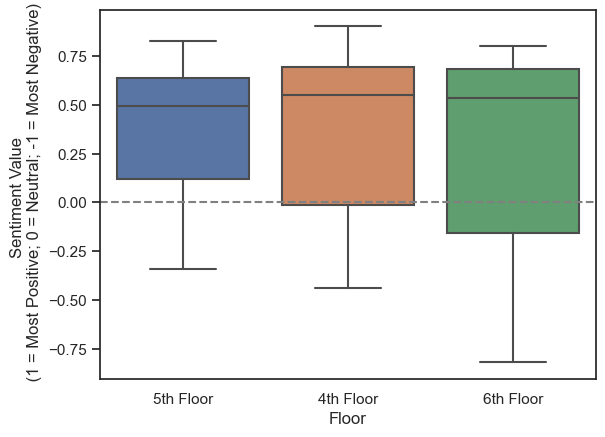

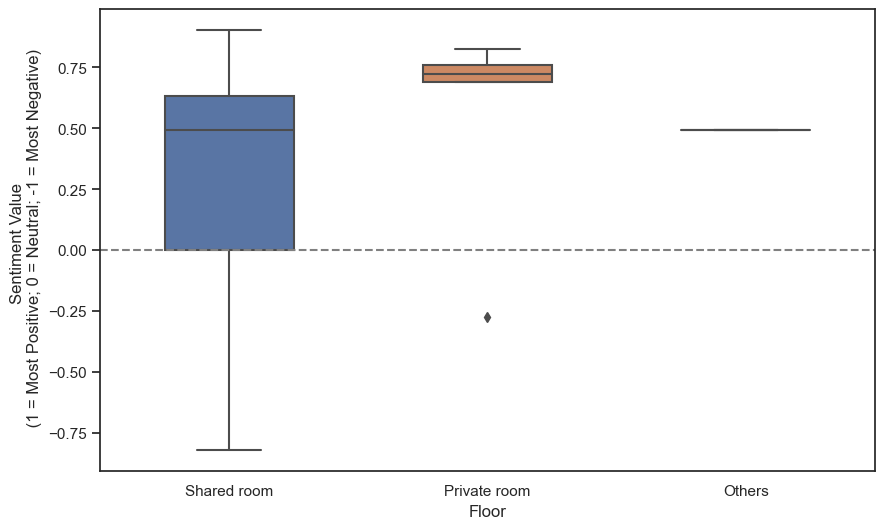

In [35]:
df = df.dropna(subset=['emotion'], how='all')
df_sent_emo = sentiment_analysis(df, 'emotion')
plot_sentiment_analysis(df_sent_emo, 'emotion')
plot_sentiment_analysis_spaces(df_sent_emo, "emotion")

### Emotion: `relaxed`

In [ ]:
df_sent_emo[['floor','emotion', 'emotion-sentiment']][df_sent_emo['emotion'].str.contains("relaxed")==True]

In [ ]:
for row in df_sent_emo['emotion'][df_sent_emo['emotion'].str.contains("calm")==True]:
    print(row)

## Comfort:

Most positive emotion statement:  ['5th Floor' 'Shared room' nan
 "I feel anxious a lot of the time but that is also because of my colleagues because I don't like them. I feel the surroundings seem clean but also cold."
 'THere is a lot of natural light, which is good. But also bright office lighting, a bit too much i think. I really do think the space could be furnished more cosy, like at ILLC (go check it out, they even have books and real kitchen towels)'
 {'neg': 0.136, 'neu': 0.749, 'pos': 0.116, 'compound': 0.0989}
 {'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'compound': 0.8812} 0.0 0.777
 0.223 0.8812 'positive']


Most negative emotion statement:  ['4th Floor' 'Shared room' nan
 'Calm, but also overwhelmed by things to do. The room feels somewhat like a refuse but at the same time it doesn’t.'
 'Reasonable. The chair is not great but OK. The light from outside is great and very real. My desk contains my stuff. '
 {'neg': 0.095, 'neu': 0.676, 'pos': 0.229, 'compound': 0.3352}
 {'ne

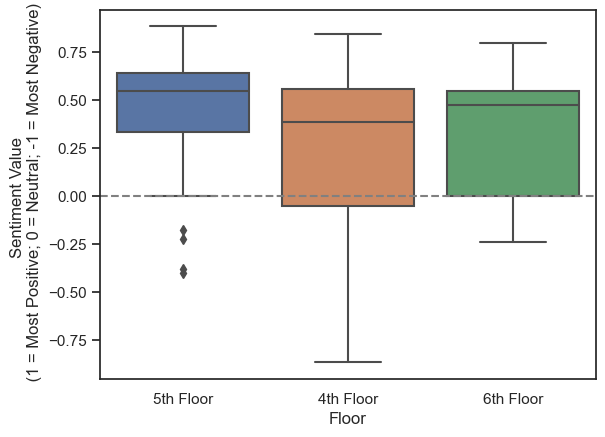

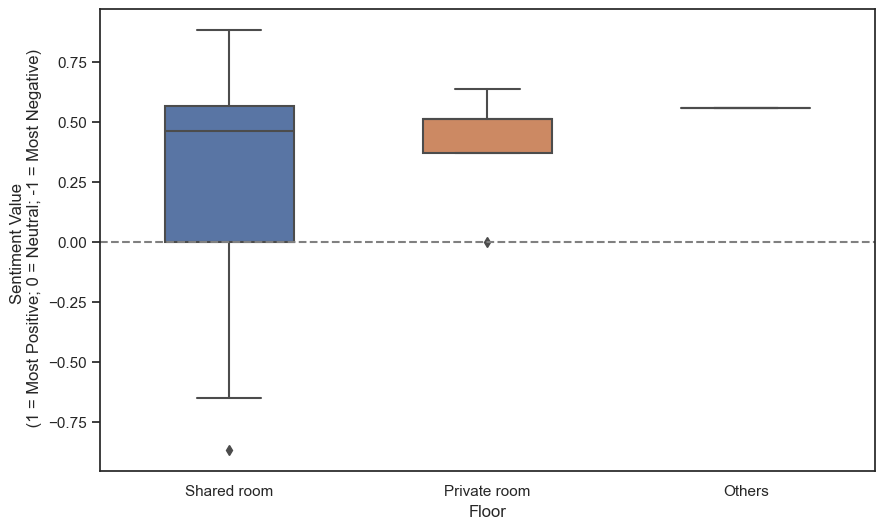

In [37]:
df = df.dropna(subset=['comfort'], how='all')
df_sent_comfort = sentiment_analysis(df, 'comfort')
plot_sentiment_analysis(df_sent_comfort, 'comfort')
plot_sentiment_analysis_spaces(df_sent_comfort, "comfort")

In [ ]:
df_sent_comfort.groupby('space-type')[['compound']].plot.bar()

In [ ]:
df_sent_comfort[df_sent_comfort['comfort'].str.contains("loud")==True]


In [ ]:
for row in df_sent_comfort['comfort'][df_sent_comfort['comfort'].str.contains("comfortable")==True]:
    print(row, "\n")